# Partie analyse de données

In [13]:
# Functions imports

import tqdm as notebook_tqdm

# Data Management

import importlib
import functions
from dateutil import tz
import pandas as pd
from scipy import stats

# Transformation des variables

from sklearn.preprocessing import StandardScaler

# Machine Learning

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

# Functions' imports

importlib.reload(functions)
from functions import *

# Displaying options 

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## Ajout des fichiers


In [14]:
x = pd.read_csv("../data/raw/X_train_Wwou3IE.csv")  # 10605 rows × 10 columns
x_challenge = pd.read_csv("../data/raw/X_test_GgyECq8.csv")  # 4942 rows × 10 columns
y = pd.read_csv("../data/raw/y_train_jJtXgMX.csv")  # 10605 rows × 2 columns

# Analyse de 'DELIVERY_START'

In [15]:
# Comme y'a beaucoup d'information contenue dans la colonne 'DELIVERY_START', nous créons
# plusieurs colonnes permettant de prendre toutes ces informations en compte

# FAIRE RUN ALL SUR CETTE CELLE LÀ À CHAQUES FOIS SINON ÇA FAIT DES ERREURS


# Extraction des caractéristiques temporelles
def add_time_features(
    df: pd.DataFrame, time_column: str
):  # Je fais une fonction car il y a plusieurs DataFrame

    df[time_column] = pd.to_datetime(
        df[time_column], errors="coerce", utc=True
    )  # Important pour pouvoir utiliser .dt
    if df[time_column].isnull().any():
        print(
            f"Warning: Some dates in column '{time_column}' could not be converted and are set to NaT"
        )

    # Gros problème, au niveau des changements d'heure, au lieu d'avoir '+1' dans DELIVERY_START
    # on a '+2' et pyhton comprend plus que c'est un date et fait crasher la fonction
    # En cherchant sur internet, j'ai trouvé qu'il fallait rajouté 'utc' dans l'argument de la fonction
    # datetime. Je rajoute une ligne pour faire une conversion en fuseau horaire local.

    # df[time_column] = df[time_column].dt.tz_convert('Europe/Paris') # Pas forcément utile

    df["hour"] = df[time_column].dt.hour
    df["day_of_week"] = df[time_column].dt.dayofweek
    df["day_of_month"] = df[time_column].dt.day
    df["month"] = df[time_column].dt.month
    df["is_weekend"] = df[time_column].dt.dayofweek > 5
    df["is_peak_hour"] = df[time_column].dt.hour.isin(range(7, 19))

    df["is_weekend"] = df["is_weekend"].astype(int)  # Pour avoir des 1/0 et pas un Boolean
    df["is_peak_hour"] = df["is_peak_hour"].astype(int)

    return df


# Appliquer les transformations sur x et x_challenge
x = add_time_features(x, "DELIVERY_START")
x_challenge = add_time_features(x_challenge, "DELIVERY_START")

x.head(1)
# x_challenge.head(1)

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nuclear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,hour,day_of_week,day_of_month,month,is_weekend,is_peak_hour
0,2022-01-01 01:00:00+00:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN,1,5,1,1,0,0


In [16]:
spot_columns(x)

Column 'DELIVERY_START' : 0 NaN values
Column 'load_forecast' : 1287 NaN values
Column 'coal_power_available' : 1 NaN values
Column 'gas_power_available' : 1 NaN values
Column 'nuclear_power_available' : 1 NaN values
Column 'wind_power_forecasts_average' : 24 NaN values
Column 'solar_power_forecasts_average' : 24 NaN values
Column 'wind_power_forecasts_std' : 24 NaN values
Column 'solar_power_forecasts_std' : 24 NaN values
Column 'predicted_spot_price' : 8759 NaN values
Column 'hour' : 0 NaN values
Column 'day_of_week' : 0 NaN values
Column 'day_of_month' : 0 NaN values
Column 'month' : 0 NaN values
Column 'is_weekend' : 0 NaN values
Column 'is_peak_hour' : 0 NaN values


In [17]:
spot_columns(x_challenge)

Column 'DELIVERY_START' : 0 NaN values
Column 'load_forecast' : 0 NaN values
Column 'coal_power_available' : 0 NaN values
Column 'gas_power_available' : 0 NaN values
Column 'nuclear_power_available' : 0 NaN values
Column 'wind_power_forecasts_average' : 0 NaN values
Column 'solar_power_forecasts_average' : 24 NaN values
Column 'wind_power_forecasts_std' : 0 NaN values
Column 'solar_power_forecasts_std' : 24 NaN values
Column 'predicted_spot_price' : 1536 NaN values
Column 'hour' : 0 NaN values
Column 'day_of_week' : 0 NaN values
Column 'day_of_month' : 0 NaN values
Column 'month' : 0 NaN values
Column 'is_weekend' : 0 NaN values
Column 'is_peak_hour' : 0 NaN values


/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() ins

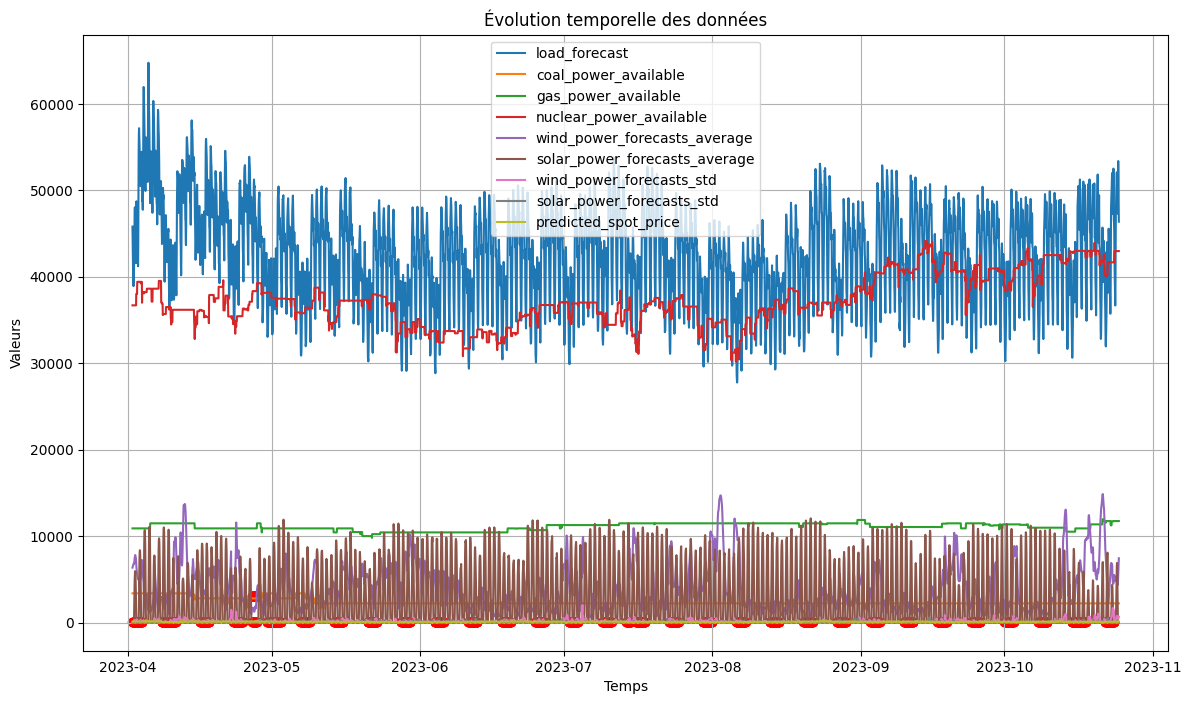

/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() ins

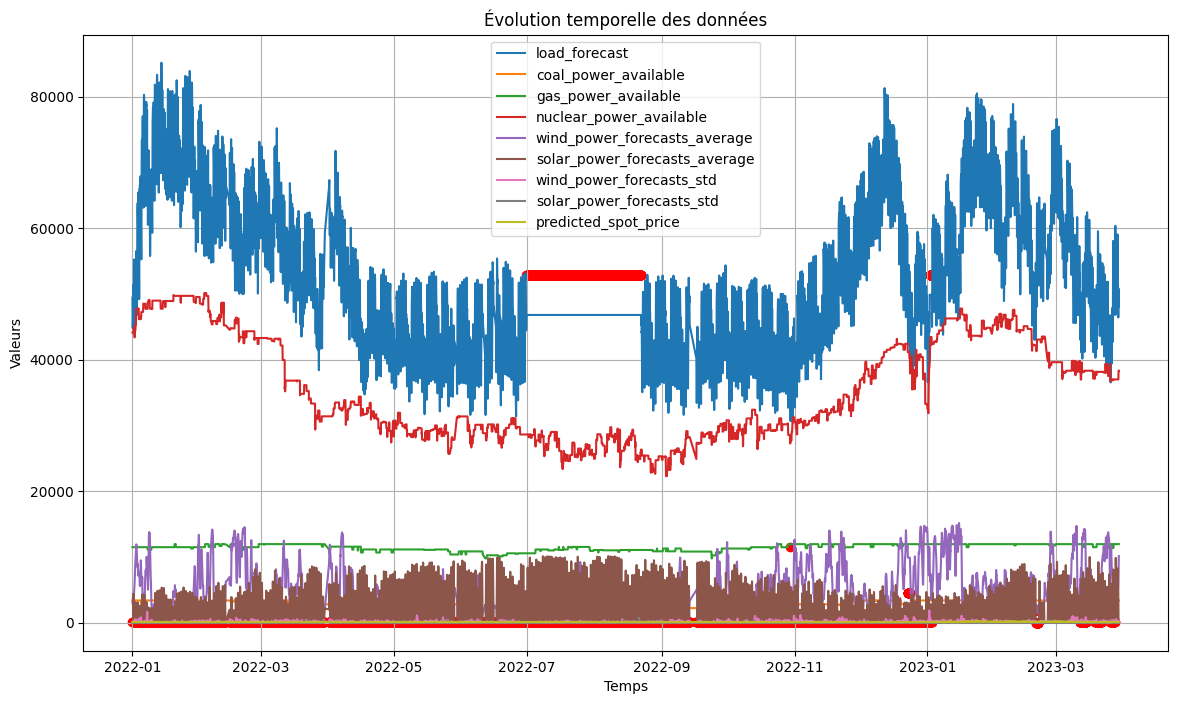

In [18]:
# On va régarder l'évolution temporelle des données pour décider comment fillna 

cols_to_plot = [
    'load_forecast', 
    'coal_power_available', 'gas_power_available', 'nuclear_power_available',
    'wind_power_forecasts_average', 'solar_power_forecasts_average',
    'wind_power_forecasts_std', 'solar_power_forecasts_std',
    'predicted_spot_price'
]

plot_time_series_with_nans(x_challenge, 'DELIVERY_START', cols_to_plot, 'bfill')
plot_time_series_with_nans(x, 'DELIVERY_START', cols_to_plot, 'bfill')

In [19]:
spot_columns(x_challenge)

Column 'DELIVERY_START' : 0 NaN values
Column 'load_forecast' : 0 NaN values
Column 'coal_power_available' : 0 NaN values
Column 'gas_power_available' : 0 NaN values
Column 'nuclear_power_available' : 0 NaN values
Column 'wind_power_forecasts_average' : 0 NaN values
Column 'solar_power_forecasts_average' : 0 NaN values
Column 'wind_power_forecasts_std' : 0 NaN values
Column 'solar_power_forecasts_std' : 0 NaN values
Column 'predicted_spot_price' : 0 NaN values
Column 'hour' : 0 NaN values
Column 'day_of_week' : 0 NaN values
Column 'day_of_month' : 0 NaN values
Column 'month' : 0 NaN values
Column 'is_weekend' : 0 NaN values
Column 'is_peak_hour' : 0 NaN values


# Exploratory Data Analysis (EDA)

Recherche de valeurs aberrantes

Analyse univariée

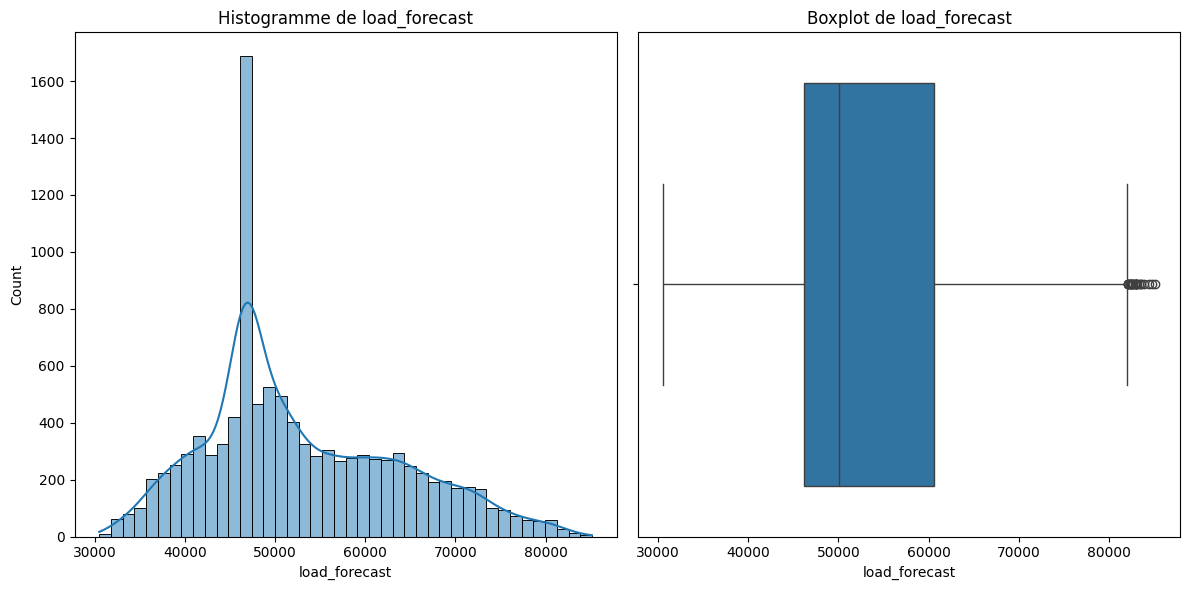

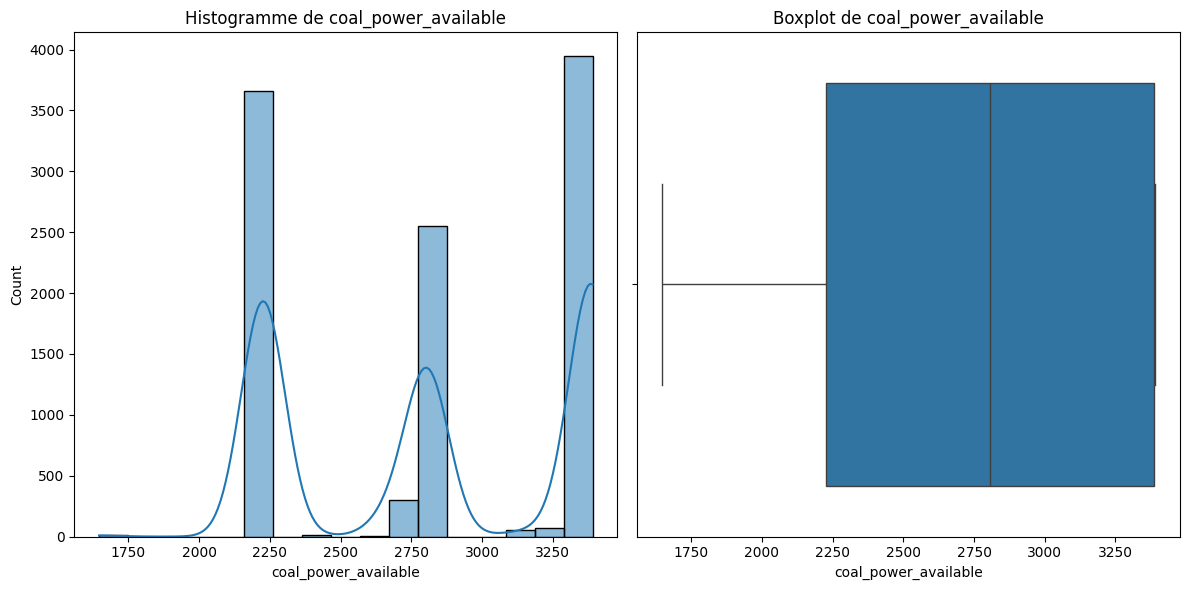

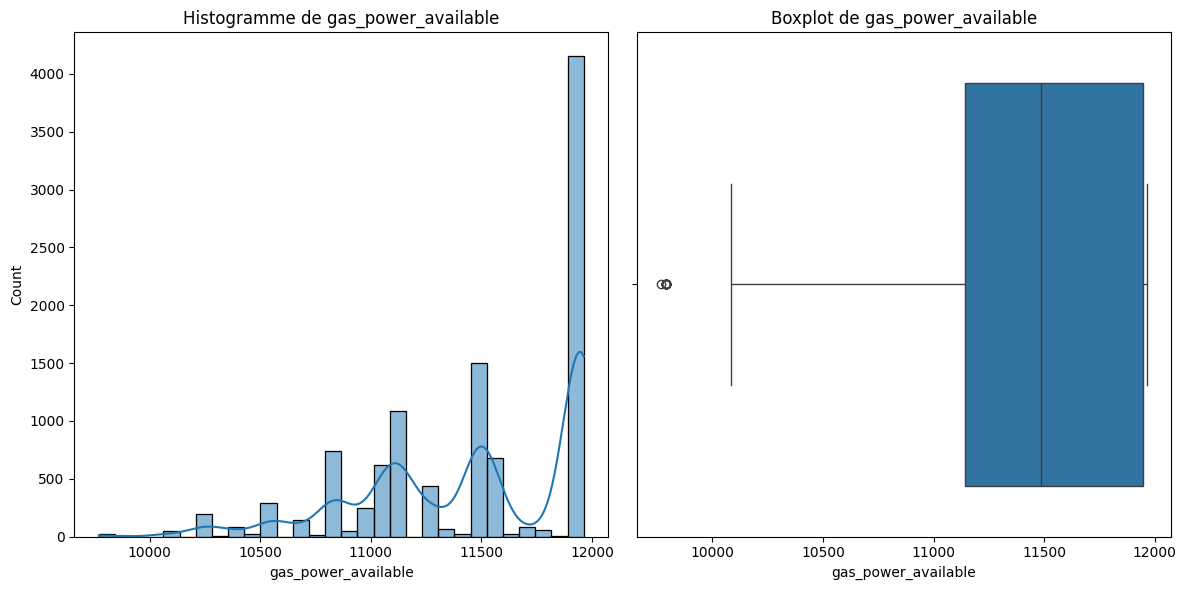

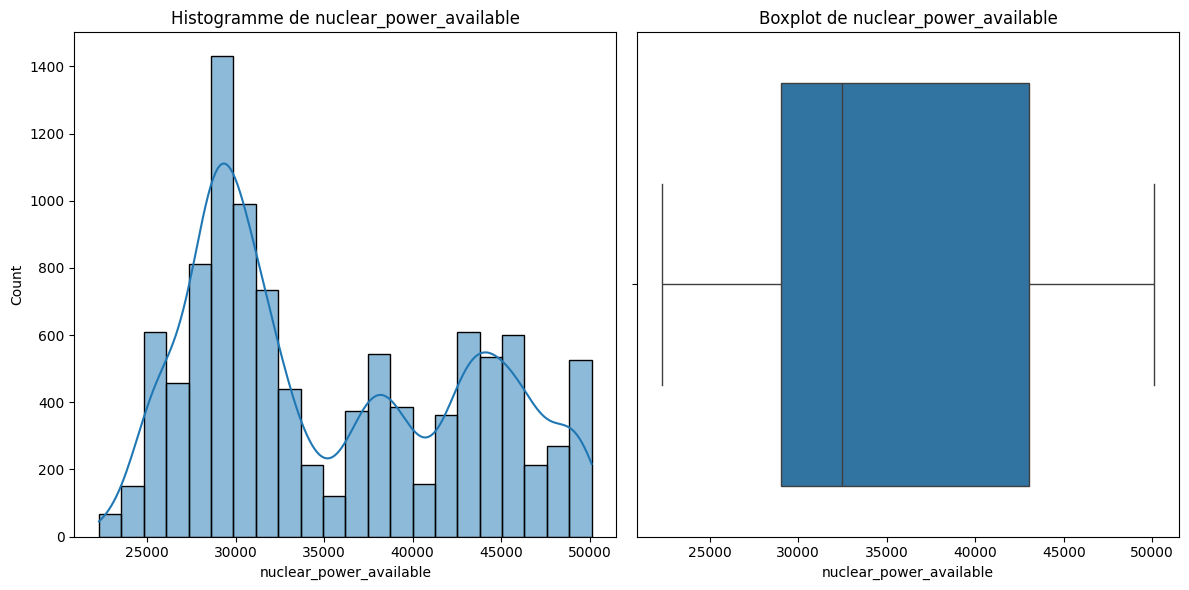

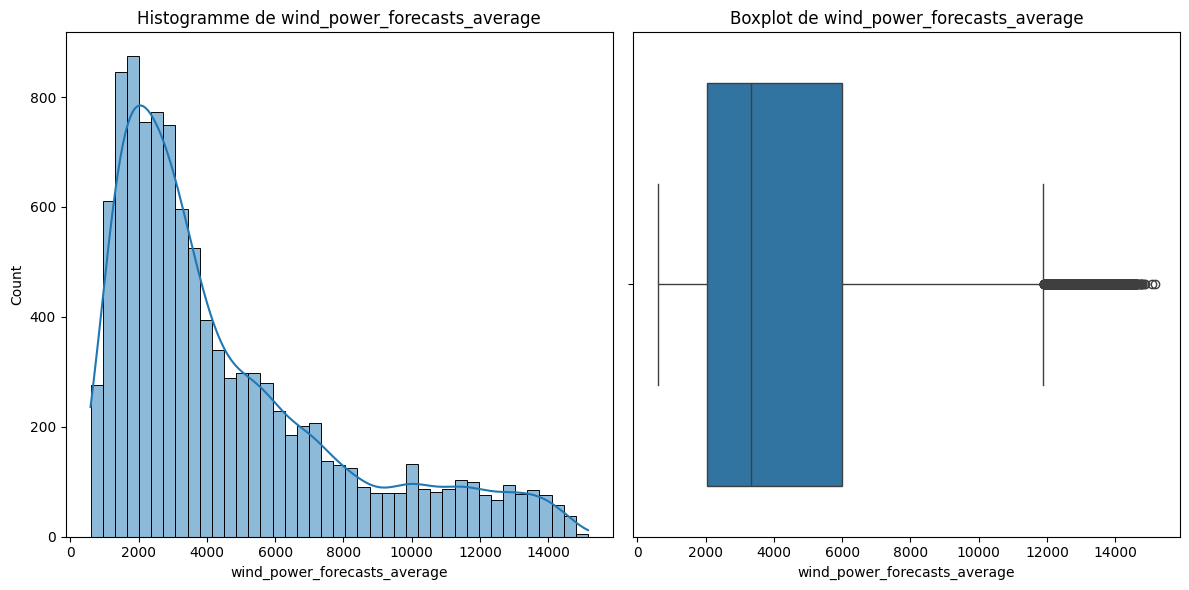

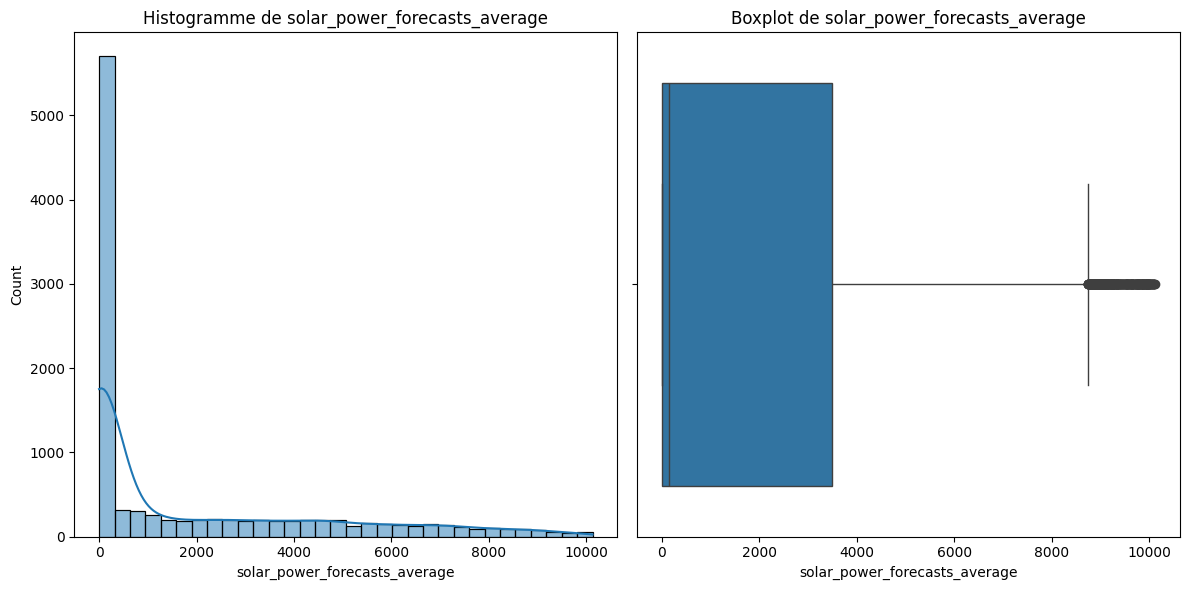

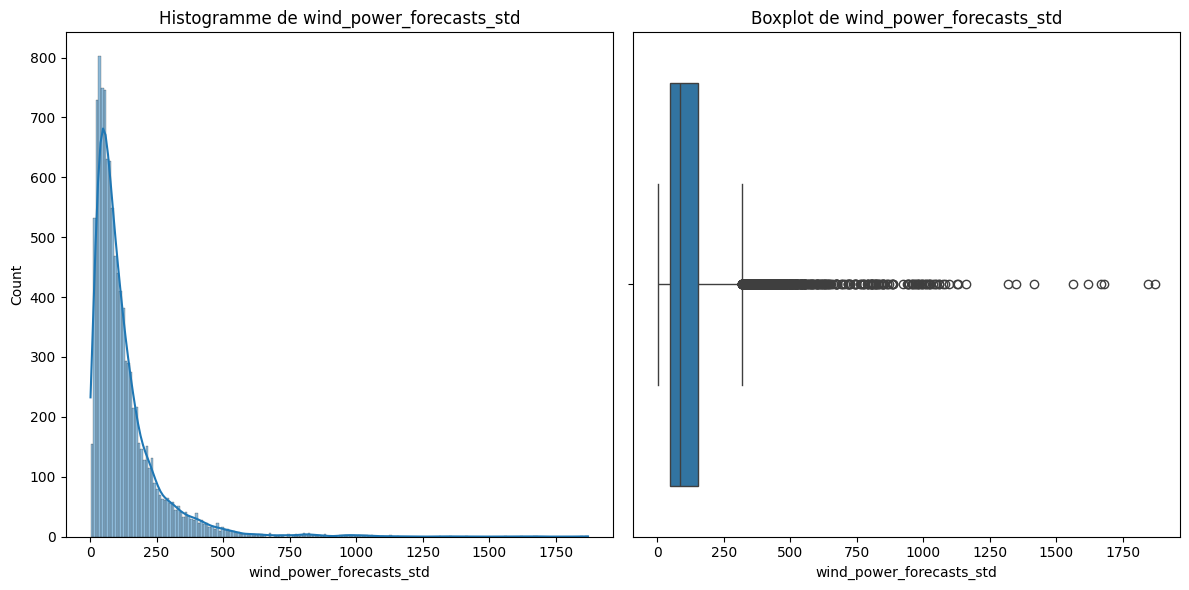

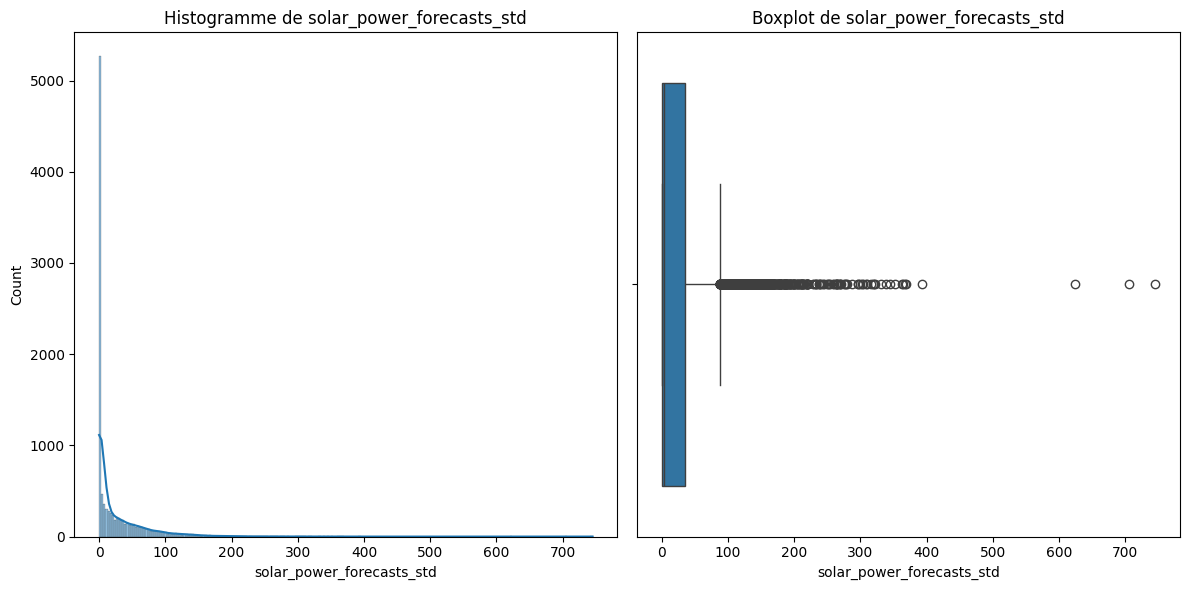

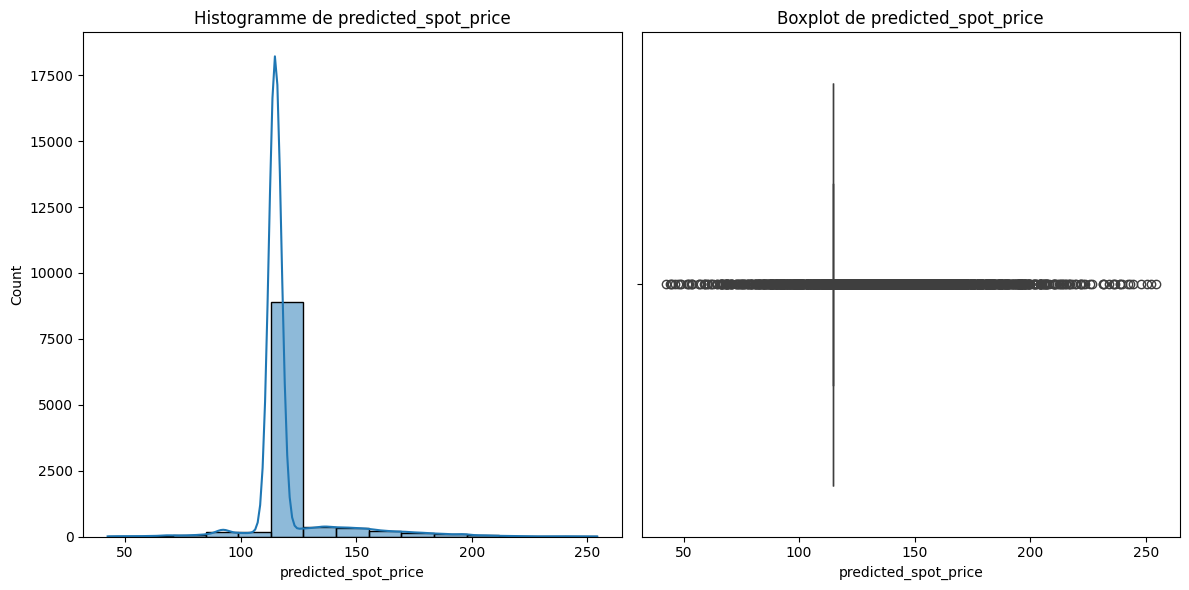

In [20]:
deviant_columns = [
    'load_forecast', 
    'coal_power_available', 'gas_power_available', 'nuclear_power_available',
    'wind_power_forecasts_average','solar_power_forecasts_average',
    'wind_power_forecasts_std', 'solar_power_forecasts_std',
    'predicted_spot_price'
]

univariate_analysis(x, deviant_columns, [])

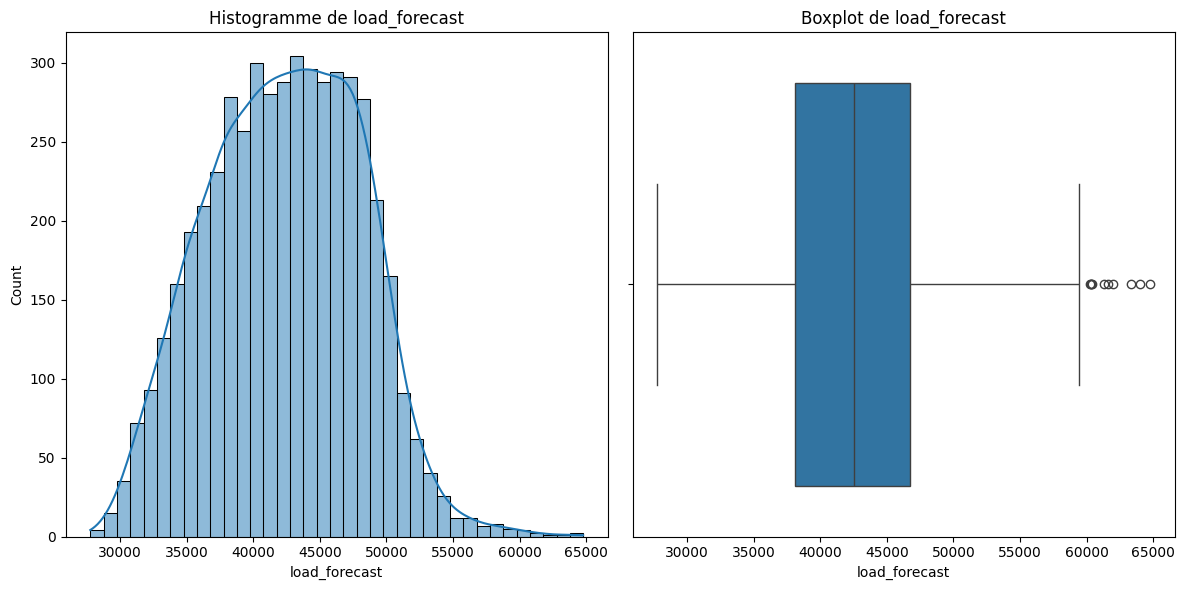

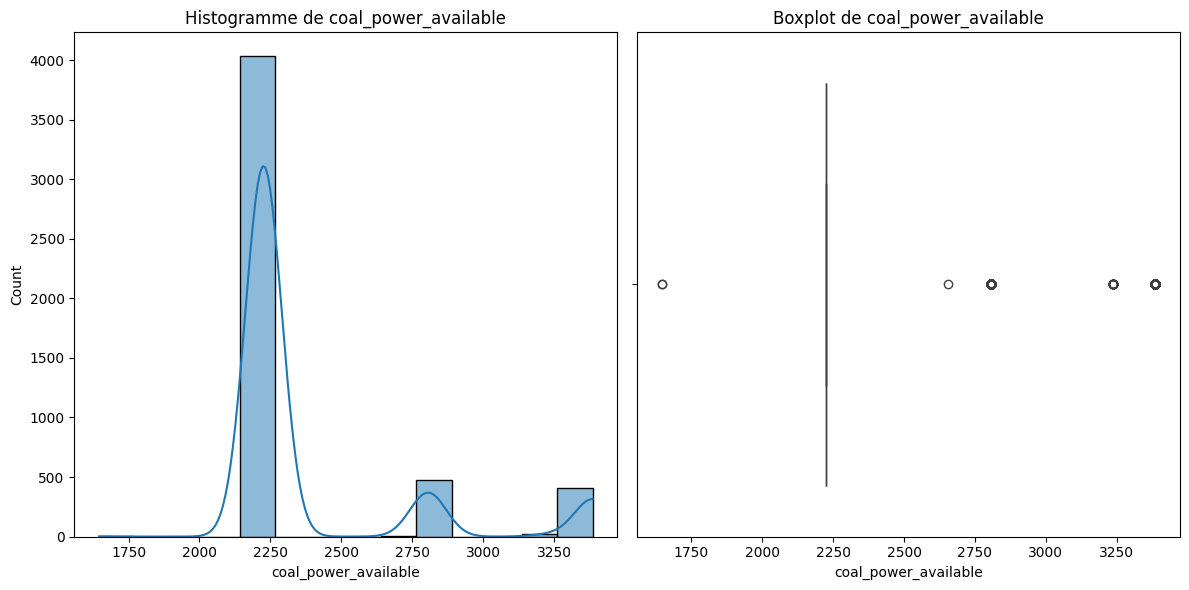

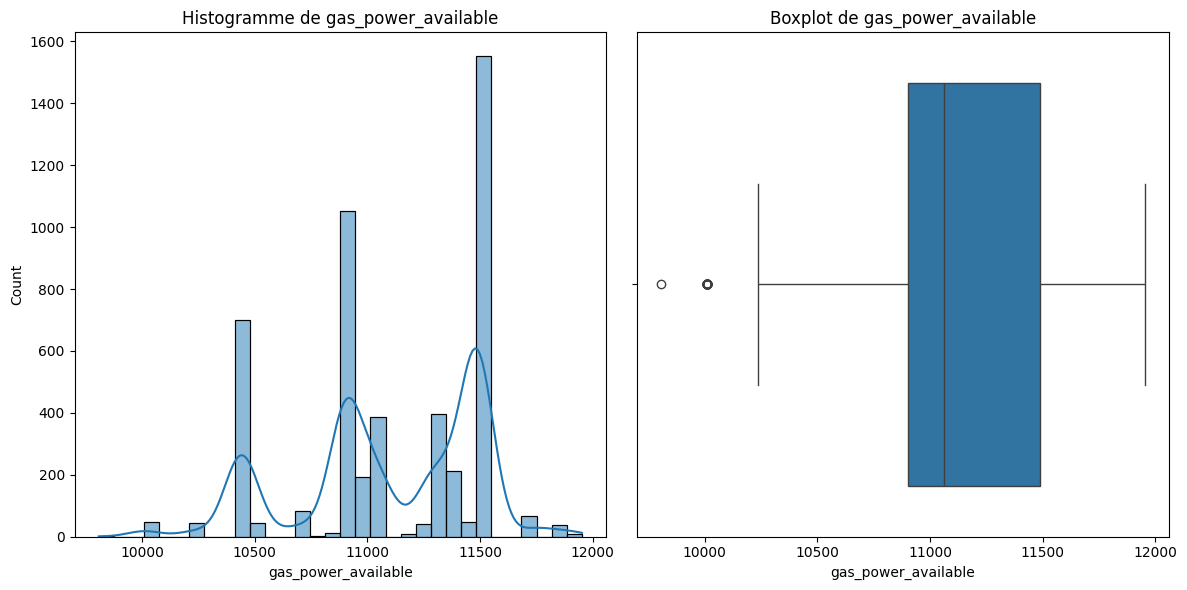

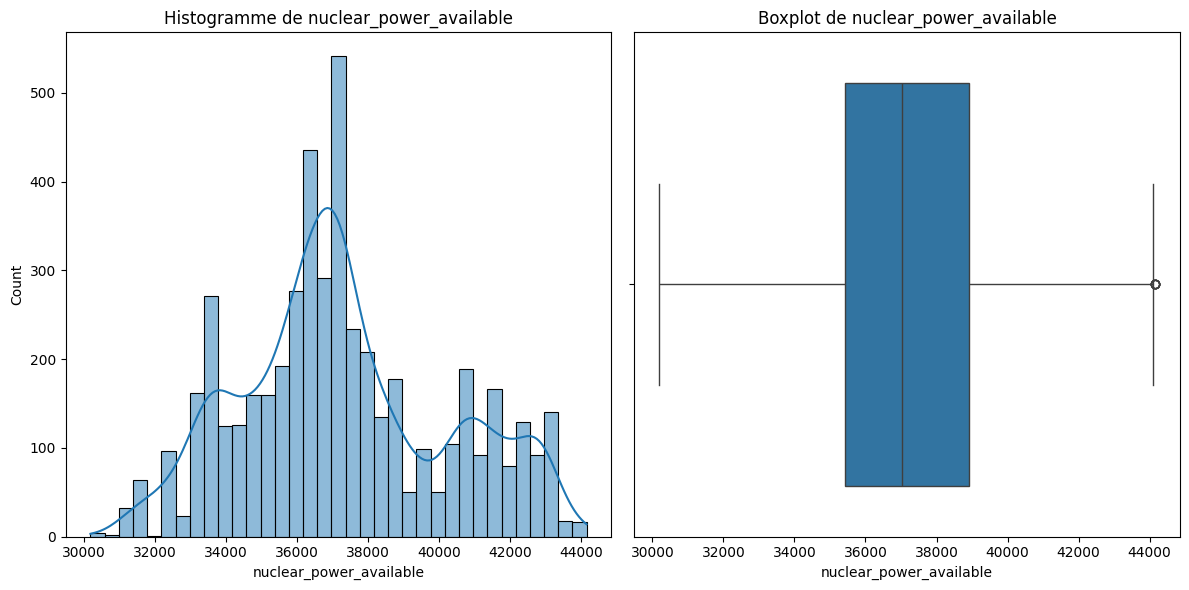

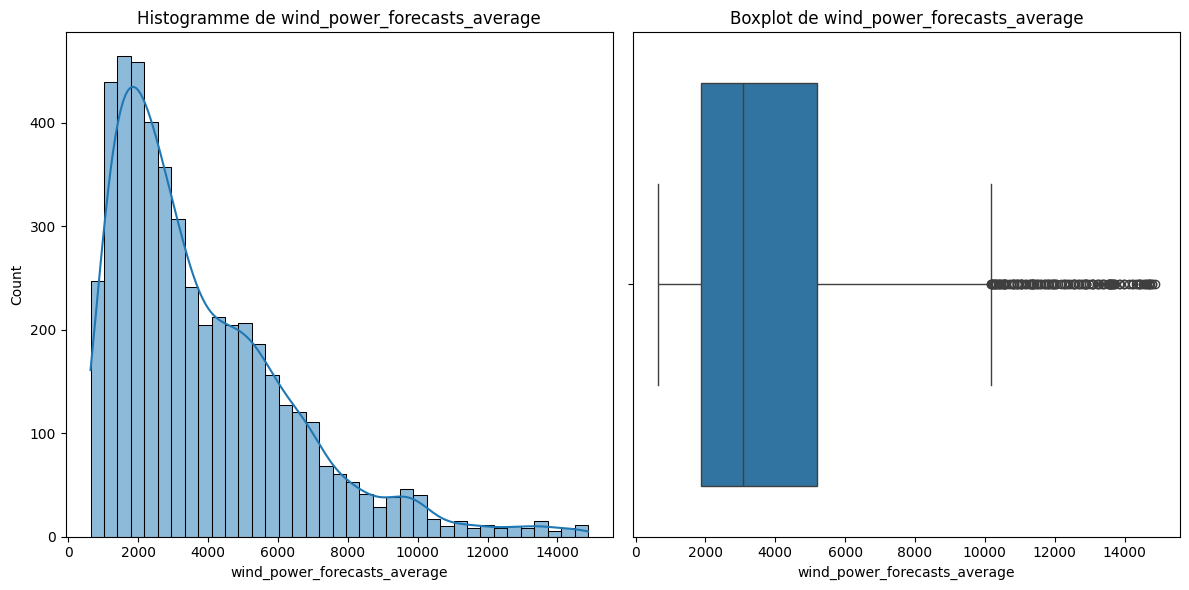

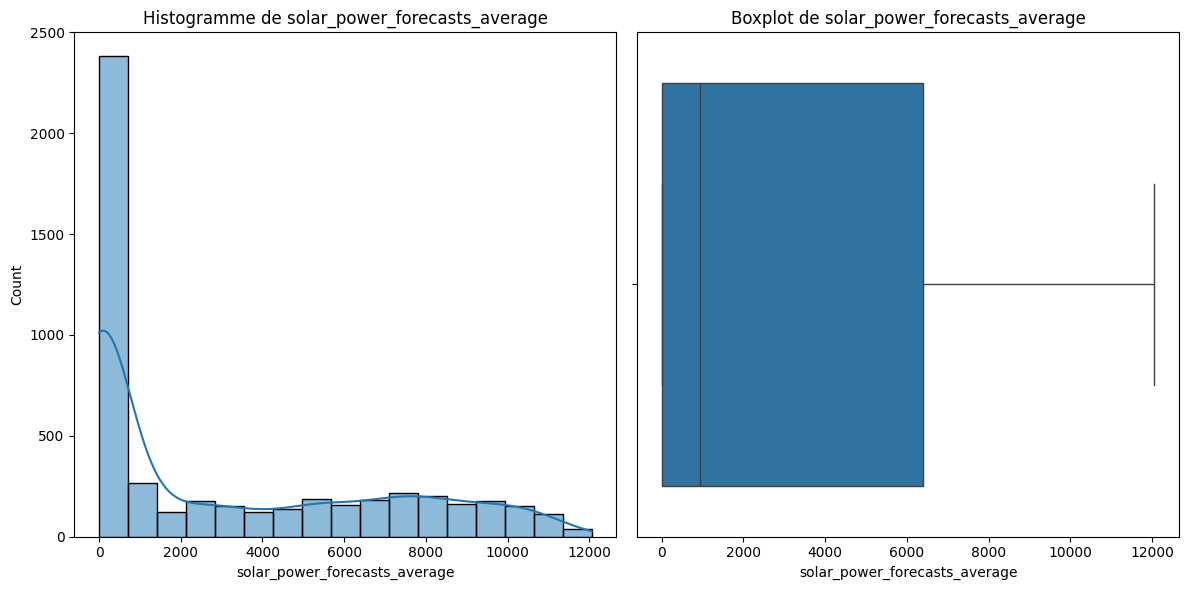

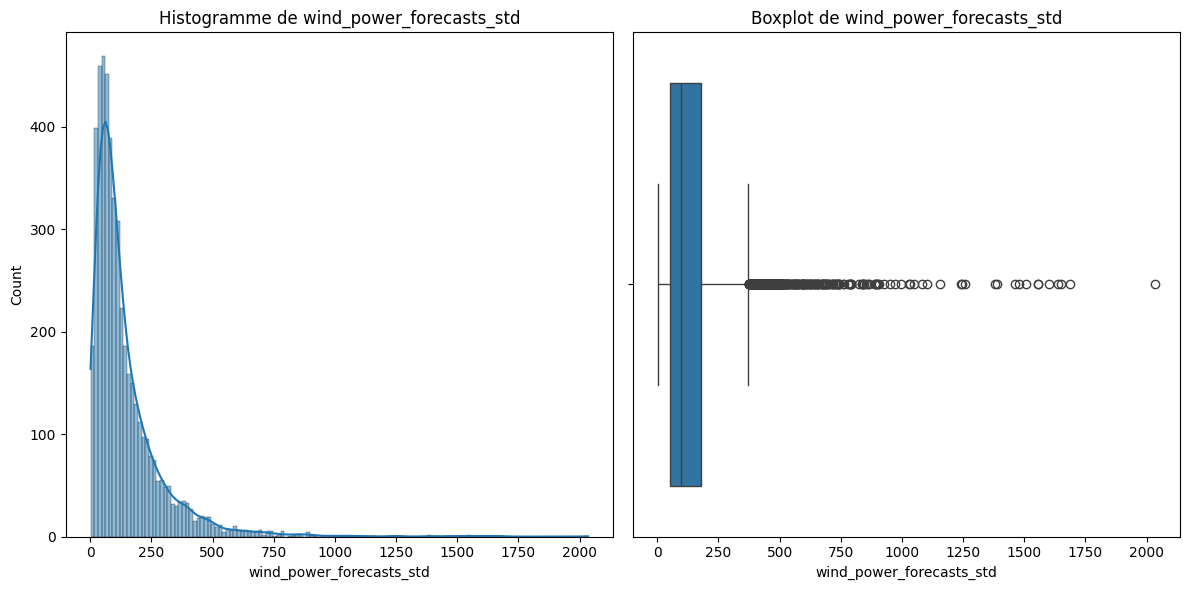

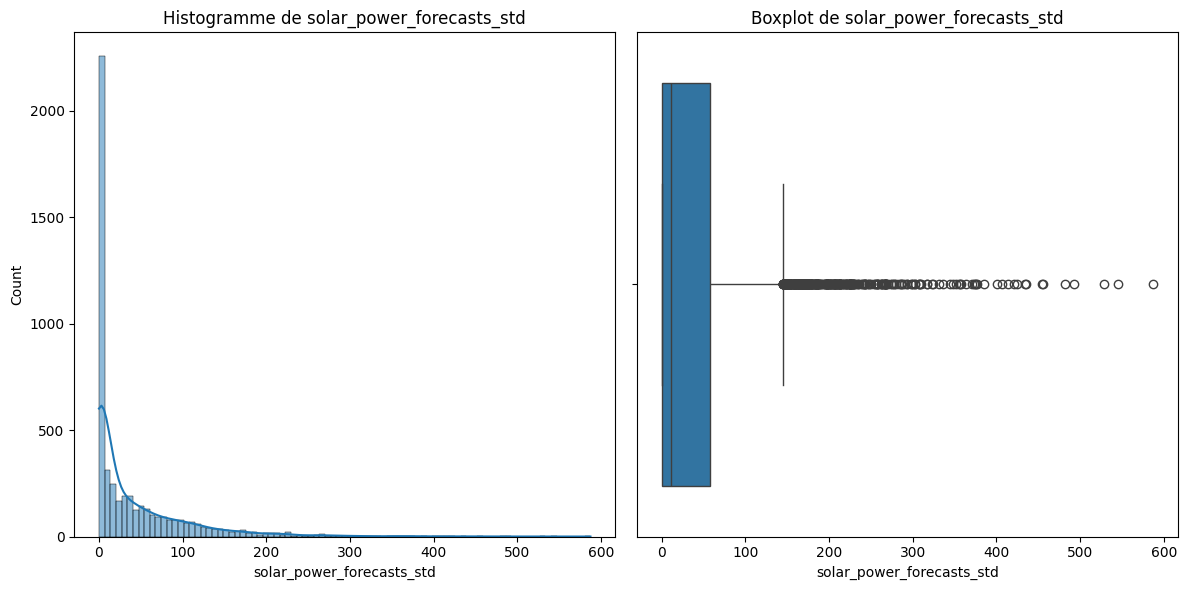

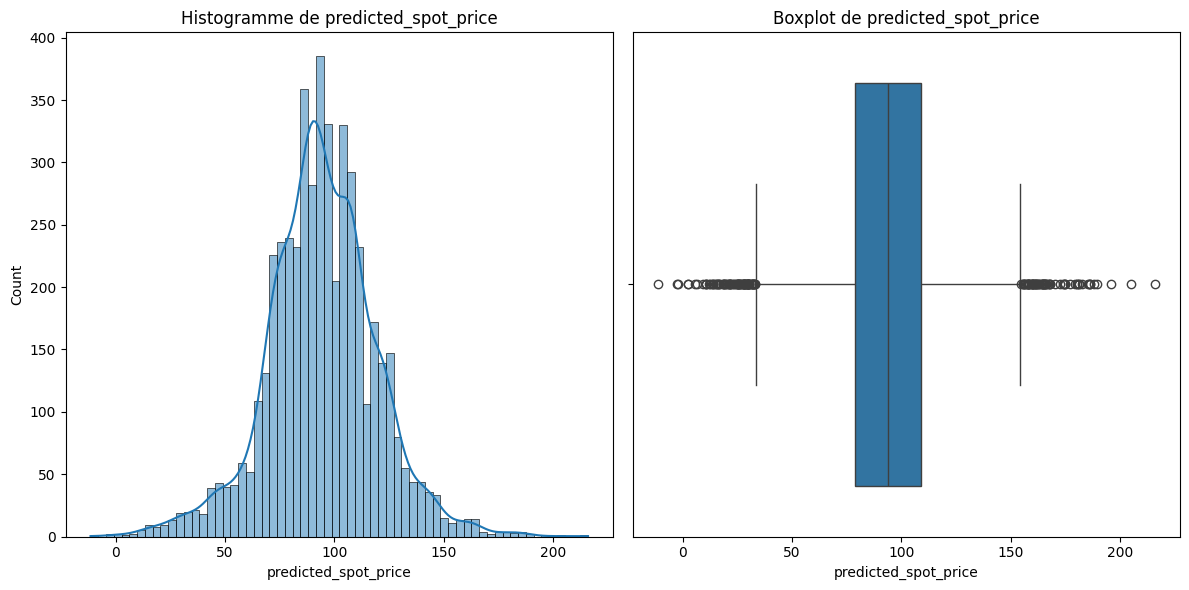

In [21]:
univariate_analysis(x_challenge, deviant_columns, [])

In [22]:
# On va maintenant essayer de remplacer les valeurs abérantes observées à l'aide de la dernière cellule 
# par la moyenne de la colonne correspondante. 

x_new = replace_outliers_z1(x, 3)
x_challenge_new = replace_outliers_z1(x_challenge, 3)

Normalisation des données

In [23]:
# scaler = StandardScaler()

# scaler.fit(x[deviant_columns])

# x_scaled = x.copy()
# x_challenge_scaled = x_challenge.copy()

# x_scaled[deviant_columns] = scaler.transform(x[deviant_columns])
# x_challenge_scaled[deviant_columns] = scaler.transform(x_challenge[deviant_columns])

# x_challenge_scaled.head(5)

Export des DataFrames

In [24]:
x_new.to_csv('../data/processed/x_processed.csv', index=False)
x_challenge_new.to_csv('../data/processed/x_challenge_processed.csv', index=False)